# Imports

In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm

%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer


from collections import Counter

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import shap
import optuna

In [354]:
df_raw = pd.read_csv('survey_results_public.csv')
df_raw

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,83435,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",6,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,160500.0
83435,83436,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Benin,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",4,...,18-24 years old,Man,No,Straight / Heterosexual,Black or of African descent,None of the above,None of the above,Appropriate in length,Easy,3960.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,New Jersey,NaN,"Secondary school (e.g. American high school, G...",11 - 17 years,School,10,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,Online Courses or Certification;Books / Physic...,5,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a mood or emotional disorder (e.g. depr...,Appropriate in length,Neither easy nor difficult,816816.0


In [355]:
df_raw.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'US_State',
       'UK_Country', 'EdLevel', 'Age1stCode', 'LearnCode', 'YearsCode',
       'YearsCodePro', 'DevType', 'OrgSize', 'Currency', 'CompTotal',
       'CompFreq', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith',
       'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
       'PlatformHaveWorkedWith', 'PlatformWantToWorkWith',
       'WebframeHaveWorkedWith', 'WebframeWantToWorkWith',
       'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
       'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith',
       'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSys',
       'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq',
       'SOComm', 'NEWOtherComms', 'Age', 'Gender', 'Trans', 'Sexuality',
       'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
       'SurveyEase', 'ConvertedCompYearly'],
      dtype='object')

# Cleaning

## Dropping Unimportant Columans

In [356]:
cols_drop = ['US_State', 'UK_Country', 'Age1stCode', 'LearnCode', 'Currency', 
             'CompTotal', 'CompFreq', 'LanguageWantToWorkWith', 
             'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 
             'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
             'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 
             'NEWCollabToolsWantToWorkWith', 'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 
             'SOAccount', 'SOComm', 'NEWOtherComms', 'Age', 'Gender', 'Trans', 'Sexuality',
             'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
             'SurveyEase']

In [357]:
df_drop = df_raw.drop(columns=cols_drop, axis=0)
df_drop.dropna(inplace=True)
# df_drop.Country.unique()

In [358]:
data_dev_list = ['Data scientist or machine learning specialist', 'Database administrator', 'Data or business analyst', 'Engineer, data']
ser_dev = df_drop['DevType'].str.split(';')
index_list = []
for idx, elem in ser_dev.iteritems():
    for item in elem:
        if item in data_dev_list:
            index_list.append(idx)
            break
df_devs = df_drop.loc[index_list,:]
df_devs

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,ConvertedCompYearly
31,32,I am a developer by profession,Employed full-time,Israel,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,2,"Engineer, data;Developer, back-end","5,000 to 9,999 employees",Bash/Shell;Go;Java;Node.js;Python;Scala;SQL,DynamoDB;MongoDB;MySQL;PostgreSQL,AWS;Google Cloud Platform;Microsoft Azure,MacOS,A few times per month or weekly,122580.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,22644.0
62,63,"I am not primarily a developer, but I write co...",Employed full-time,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,5,"Developer, front-end;Developer, desktop or ent...","10,000 or more employees",C#;HTML/CSS;JavaScript;Node.js;PowerShell;Pyth...,Microsoft SQL Server;Oracle;SQLite,AWS;IBM Cloud or Watson;Microsoft Azure,Windows,Multiple times per day,130000.0
64,65,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",United States of America,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,5,"Developer, front-end;Developer, desktop or ent...",2 to 9 employees,HTML/CSS;JavaScript;Python,MySQL,AWS,Linux-based,A few times per month or weekly,500000.0
77,78,I am a developer by profession,Employed full-time,Canada,"Other doctoral degree (Ph.D., Ed.D., etc.)",10,8,Data scientist or machine learning specialist,500 to 999 employees,HTML/CSS;Python;R,DynamoDB,AWS,MacOS,A few times per week,151263.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83390,83391,I am a developer by profession,Employed full-time,Brazil,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",21,18,"Developer, front-end;Developer, full-stack;Dev...",2 to 9 employees,Dart;HTML/CSS;JavaScript;Node.js;PHP;SQL;TypeS...,Firebase;MongoDB;MySQL,AWS,Linux-based,Less than once per month or monthly,27492.0
83392,83393,I am a developer by profession,Employed full-time,Brazil,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,5,Data scientist or machine learning specialist;...,20 to 99 employees,Bash/Shell;Julia;PowerShell;Python;R,Cassandra;MongoDB,AWS,Windows,I have never participated in Q&A on Stack Over...,68721.0
83401,83402,I am a developer by profession,Employed full-time,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11,2,"Developer, front-end;Developer, full-stack;Dev...",2 to 9 employees,Bash/Shell;F#;HTML/CSS;JavaScript;Node.js;SQL,PostgreSQL,DigitalOcean,MacOS,I have never participated in Q&A on Stack Over...,70000.0
83431,83432,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Pakistan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,4,"Developer, mobile;Developer, desktop or enterp...",2 to 9 employees,C#;Dart;HTML/CSS;Java;JavaScript;Kotlin;Node.j...,Firebase;MySQL;SQLite,Google Cloud Platform,Windows,A few times per month or weekly,11676.0


In [359]:
# OHE_list = []
# ordinal_list = []
# for col in df_asia.columns:
#     print(col, '\n--------------')
#     display(df_asia[col].unique())
#     ans = input('action')
#     if ans == 'cat':
#         OHE_list.append(col)
#     elif ans == 'ord':
#         ordinal_list.append(col)

In [360]:
OHE_list = ['Employment', 'Country', 'OpSys']

In [361]:
ordinal_list = ['MainBranch', 'EdLevel', 'OrgSize', 'SOPartFreq']

**Columns that need transformation**

In [362]:
df_devs[df_devs.columns.difference(OHE_list+ordinal_list)].head()

,ConvertedCompYearly,DatabaseHaveWorkedWith,DevType,LanguageHaveWorkedWith,PlatformHaveWorkedWith,ResponseId,YearsCode,YearsCodePro
31,122580.0,DynamoDB;MongoDB;MySQL;PostgreSQL,"Engineer, data;Developer, back-end",Bash/Shell;Go;Java;Node.js;Python;Scala;SQL,AWS;Google Cloud Platform;Microsoft Azure,32,4,2
58,22644.0,Oracle,"Developer, full-stack;Data scientist or machin...",Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Heroku,59,5,3
62,130000.0,Microsoft SQL Server;Oracle;SQLite,"Developer, front-end;Developer, desktop or ent...",C#;HTML/CSS;JavaScript;Node.js;PowerShell;Pyth...,AWS;IBM Cloud or Watson;Microsoft Azure,63,13,5
64,500000.0,MySQL,"Developer, front-end;Developer, desktop or ent...",HTML/CSS;JavaScript;Python,AWS,65,6,5
77,151263.0,DynamoDB,Data scientist or machine learning specialist,HTML/CSS;Python;R,AWS,78,10,8


## Prepping Features with top X filtering

In [363]:
def OHE_semicolon_vals(col_name, top_vals, prefix):
    li = []
    for row in df_devs[col_name].str.split(';'):
         li = li + row

    df_try = df_devs[col_name].copy().to_frame()
    top_12_lang = pd.Series(li).value_counts()[:top_vals].index
    # display(top_12_lang)
    
    df_out = df_try.copy()
    df_out.reset_index(inplace=True)
    for lang in top_12_lang:
        df_out[f'{prefix}_'+lang] = 0
    
    for idx, elem in enumerate(df_try.iloc[:,0].str.split(';')):
        for lang in top_12_lang:
            if lang in elem:
                df_out.loc[idx, f'{prefix}_' + lang] = 1 
    return df_out.set_index('index').drop(columns=col_name, axis=0)

In [364]:
lang_OHE = OHE_semicolon_vals('LanguageHaveWorkedWith', 12, 'Lang')
lang_OHE

,Lang_SQL,Lang_JavaScript,Lang_Python,Lang_HTML/CSS,Lang_Bash/Shell,Lang_Node.js,Lang_C#,Lang_Java,Lang_TypeScript,Lang_PHP,Lang_C++,Lang_PowerShell
index,,,,,,,,,,,,
31,1,0,1,0,1,1,0,1,0,0,0,0
58,1,1,1,1,1,0,0,0,0,0,0,0
62,1,1,1,1,0,1,1,0,0,0,0,1
64,0,1,1,1,0,0,0,0,0,0,0,0
77,0,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
83390,1,1,0,1,0,1,0,0,1,1,0,0
83392,0,0,1,0,1,0,0,0,0,0,0,1
83401,1,1,0,1,1,1,0,0,0,0,0,0


In [365]:
devtype_OHE = OHE_semicolon_vals('DevType', 10, 'Dev')
devtype_OHE

,"Dev_Developer, back-end","Dev_Developer, full-stack",Dev_Database administrator,"Dev_Engineer, data","Dev_Developer, front-end",Dev_Data scientist or machine learning specialist,Dev_Data or business analyst,Dev_System administrator,Dev_DevOps specialist,"Dev_Developer, desktop or enterprise applications"
index,,,,,,,,,,
31,1,0,0,1,0,0,0,0,0,0
58,0,1,0,0,0,1,0,0,0,0
62,1,1,1,0,1,1,1,0,0,1
64,1,1,0,0,1,0,1,0,0,1
77,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
83390,1,1,1,0,1,0,0,0,0,0
83392,1,0,0,0,0,1,0,0,0,0
83401,1,1,1,0,1,0,0,1,1,0


In [366]:
database_OHE = OHE_semicolon_vals('DatabaseHaveWorkedWith', 10, 'DB')
database_OHE

,DB_PostgreSQL,DB_MySQL,DB_Microsoft SQL Server,DB_SQLite,DB_MongoDB,DB_Redis,DB_MariaDB,DB_Elasticsearch,DB_Oracle,DB_Firebase
index,,,,,,,,,,
31,1,1,0,0,1,0,0,0,0,0
58,0,0,0,0,0,0,0,0,1,0
62,0,0,1,1,0,0,0,0,1,0
64,0,1,0,0,0,0,0,0,0,0
77,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
83390,0,1,0,0,1,0,0,0,0,1
83392,0,0,0,0,1,0,0,0,0,0
83401,1,0,0,0,0,0,0,0,0,0


In [367]:
# PlatformHaveWorkedWith
platform_OHE = OHE_semicolon_vals('PlatformHaveWorkedWith', 10, 'Plat')
platform_OHE

,Plat_AWS,Plat_Microsoft Azure,Plat_Google Cloud Platform,Plat_DigitalOcean,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Oracle Cloud Infrastructure
index,,,,,,,
31,1,1,1,0,0,0,0
58,0,0,0,0,1,0,0
62,1,1,0,0,0,1,0
64,1,0,0,0,0,0,0
77,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
83390,1,0,0,0,0,0,0
83392,1,0,0,0,0,0,0
83401,0,0,0,1,0,0,0


Changing `YearsCode` and `YearsCodeProd` to numeric

In [368]:
df_devs['YearsCode']

31        4
58        5
62       13
64        6
77       10
         ..
83390    21
83392     7
83401    11
83431     9
83436    10
Name: YearsCode, Length: 5417, dtype: object

In [369]:
#YearsCode
def years_code_mapping(x):
    if x == 'Less than 1 year':
        return 0.5
    elif x == 'More than 50 years':
        return 55
    else:
        return int(x)

df_devs['YearsCode'] = df_devs['YearsCode'].copy().apply(years_code_mapping)
#YearsCodePro
df_devs['YearsCodePro'] = df_devs['YearsCodePro'].copy().apply(years_code_mapping)


## Ordinal Mapping 

In [370]:
df_devs['MainBranch'].unique()

array(['I am a developer by profession',
       'I am not primarily a developer, but I write code sometimes as part of my work'],
      dtype=object)

In [371]:

MainBranch_mapping = {'I am not primarily a developer, but I write code sometimes as part of my work': 0, 
                      'I am a developer by profession': 1}
df_devs['MainBranch'] = df_devs['MainBranch'].copy().map(MainBranch_mapping)

In [372]:
len(df_devs['EdLevel'].unique())

9

In [373]:
# EdLevel
EdLevel_mapping = {'Something else':0, 
                   'Primary/elementary school': 1, 
                   'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2, 
                   'Some college/university study without earning a degree': 3,
                   'Associate degree (A.A., A.S., etc.)':4,
                   'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5, 
                   'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':6, 
                   'Other doctoral degree (Ph.D., Ed.D., etc.)':7, 
                   'Professional degree (JD, MD, etc.)':8}

df_devs['EdLevel'] = df_devs['EdLevel'].copy().map(EdLevel_mapping)
# df_asia
# df_asia['EdLevel']

In [374]:
len(df_devs['OrgSize'].unique())

10

In [375]:
OrgSize_mapping = {
    'I don’t know':0,
    'Just me - I am a freelancer, sole proprietor, etc.':1,
    '2 to 9 employees':2,
    '10 to 19 employees':3,
    '20 to 99 employees':4,
    '100 to 499 employees':5,
    '500 to 999 employees':6,
    '1,000 to 4,999 employees':7,
    '5,000 to 9,999 employees':8,
    '10,000 or more employees':9
}

df_devs['OrgSize'] = df_devs['OrgSize'].copy().map(OrgSize_mapping)

In [376]:
len(df_devs['SOPartFreq'].unique())

6

In [377]:
df_devs['SOPartFreq'].unique()

SOPartFreq_mapping = {
    'I have never participated in Q&A on Stack Overflow': 0,
    'Less than once per month or monthly':1,
    'A few times per month or weekly':2,
    'A few times per week':3,
    'Daily or almost daily':4,
    'Multiple times per day':5
}
df_devs['SOPartFreq'] = df_devs['SOPartFreq'].copy().map(SOPartFreq_mapping)

In [378]:
df_devs[ordinal_list]

,MainBranch,EdLevel,OrgSize,SOPartFreq
31,1,5,8,2
58,0,8,4,1
62,0,5,9,5
64,0,6,2,2
77,1,7,6,3
...,...,...,...,...
83390,1,5,2,1
83392,1,5,4,0
83401,1,5,2,0
83431,1,5,2,2


## OHE

In [379]:
df_devs[OHE_list]

,Employment,Country,OpSys
31,Employed full-time,Israel,MacOS
58,Employed full-time,Russian Federation,Linux-based
62,Employed full-time,United States of America,Windows
64,"Independent contractor, freelancer, or self-em...",United States of America,Linux-based
77,Employed full-time,Canada,MacOS
...,...,...,...
83390,Employed full-time,Brazil,Linux-based
83392,Employed full-time,Brazil,Windows
83401,Employed full-time,United States of America,MacOS
83431,"Independent contractor, freelancer, or self-em...",Pakistan,Windows


In [380]:
df_devs['ConvertedCompYearly'] = df_devs['ConvertedCompYearly'].astype(int)
numeric_data = df_devs.select_dtypes(['int', 'float'])
numeric_data.index.name='index'
numeric_data

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly
index,,,,,,,,
31,32,1,5,4.0,2.0,8,2,122580
58,59,0,8,5.0,3.0,4,1,22644
62,63,0,5,13.0,5.0,9,5,130000
64,65,0,6,6.0,5.0,2,2,500000
77,78,1,7,10.0,8.0,6,3,151263
...,...,...,...,...,...,...,...,...
83390,83391,1,5,21.0,18.0,2,1,27492
83392,83393,1,5,7.0,5.0,4,0,68721
83401,83402,1,5,11.0,2.0,2,0,70000


In [381]:
OHE_data = pd.concat([lang_OHE,database_OHE, devtype_OHE, platform_OHE, pd.get_dummies(df_devs[OHE_list])], axis=1)
df_final = pd.merge(left=numeric_data, right=OHE_data, left_index=True, right_index=True)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_SQL,Lang_JavaScript,...,"Country_Venezuela, Bolivarian Republic of...",Country_Viet Nam,Country_Zambia,Country_Zimbabwe,OpSys_BSD,OpSys_Linux-based,OpSys_MacOS,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL)
index,,,,,,,,,,,,,,,,,,,,,
31,32,1,5,4.0,2.0,8,2,122580,1,0,...,0,0,0,0,0,0,1,0,0,0
58,59,0,8,5.0,3.0,4,1,22644,1,1,...,0,0,0,0,0,1,0,0,0,0
62,63,0,5,13.0,5.0,9,5,130000,1,1,...,0,0,0,0,0,0,0,0,1,0
64,65,0,6,6.0,5.0,2,2,500000,0,1,...,0,0,0,0,0,1,0,0,0,0
77,78,1,7,10.0,8.0,6,3,151263,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83390,83391,1,5,21.0,18.0,2,1,27492,1,1,...,0,0,0,0,0,1,0,0,0,0
83392,83393,1,5,7.0,5.0,4,0,68721,0,0,...,0,0,0,0,0,0,0,0,1,0
83401,83402,1,5,11.0,2.0,2,0,70000,1,1,...,0,0,0,0,0,0,1,0,0,0


# EDA

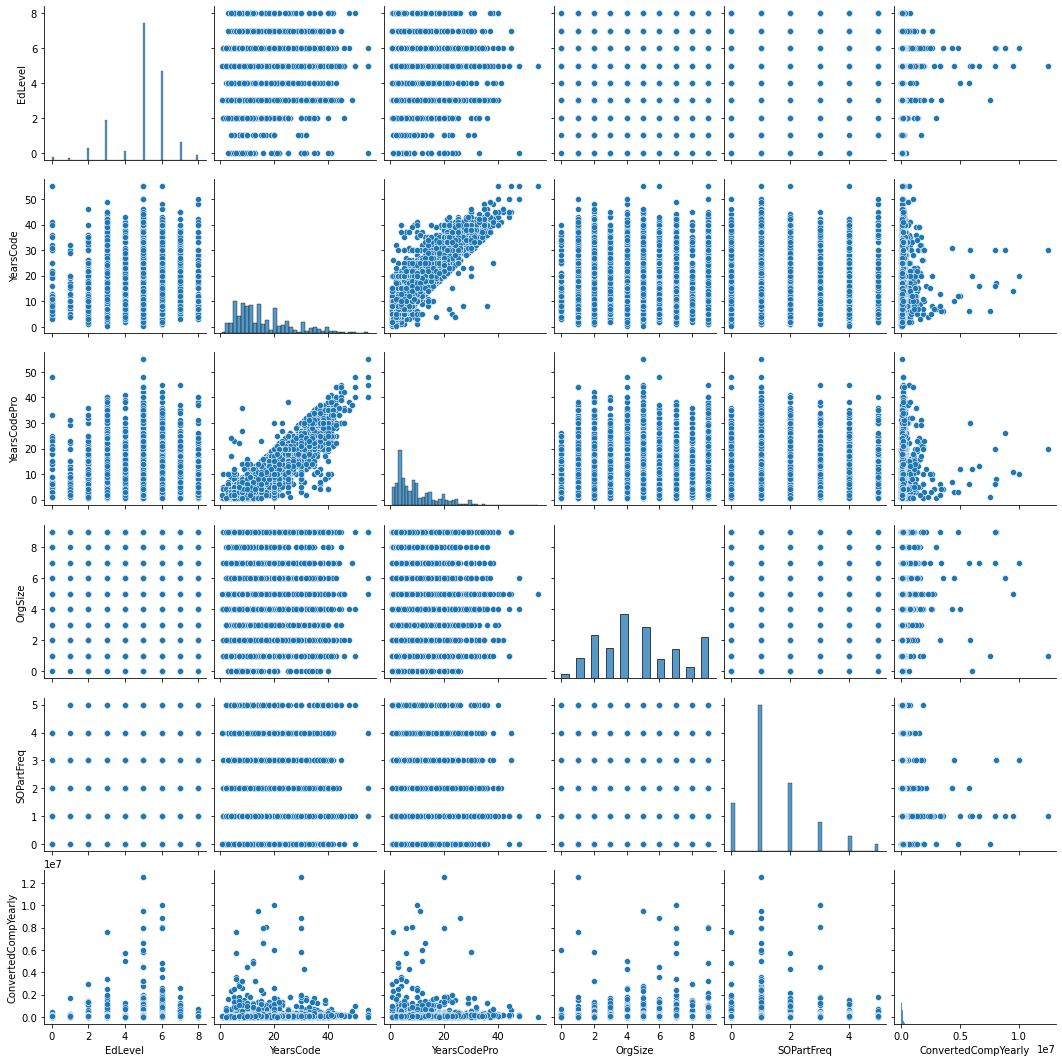

In [382]:
sns.pairplot(data=df_final[['EdLevel', 'YearsCode', 'YearsCodePro', 'OrgSize', 'SOPartFreq', 'ConvertedCompYearly']], diag_kind='hist')
plt.show()

Skewed features may need log transformation to improve model results. idk yet will initially try running models on not transformed data

<AxesSubplot:ylabel='Frequency'>

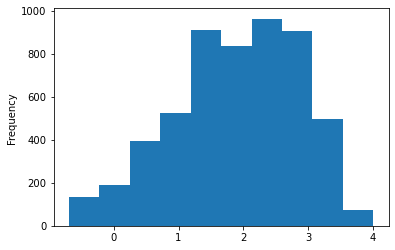

In [383]:
df_final['YearsCodePro'] = df_final['YearsCodePro'].copy().apply(np.log)
df_final['YearsCodePro'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

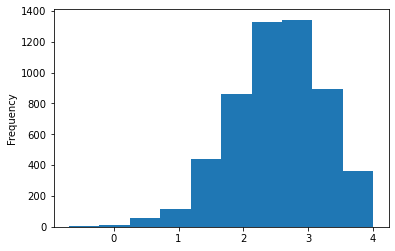

In [384]:
df_final['YearsCode'] = df_final['YearsCode'].copy().apply(np.log)
df_final['YearsCode'].plot(kind='hist')

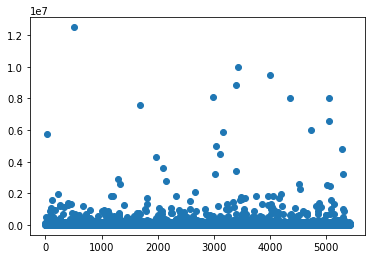

In [385]:
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

In [386]:
idx_outliers_y = df_final['ConvertedCompYearly'].sort_values(ascending=False).head(10).index.to_list()
df_final.loc[idx_outliers_y,:]
df_final = df_final.drop(idx_outliers_y, axis=0)

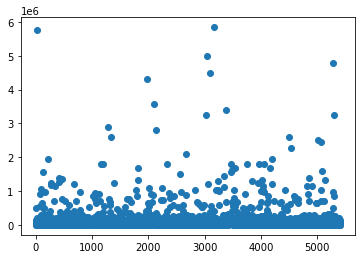

In [387]:
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

# Adding language counts as a feature

In [388]:
def filter_lang(prefix):
    li = []
    for elem in df_final.columns:
        if prefix in elem:
            li.append(elem)
    return li

lang_cols = filter_lang('Lang_')
df_final['LCount'] = df_final[lang_cols].sum(axis=1)

dev_cols = filter_lang('Dev_')
df_final['DCount'] = df_final[dev_cols].sum(axis=1)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_SQL,Lang_JavaScript,...,Country_Zambia,Country_Zimbabwe,OpSys_BSD,OpSys_Linux-based,OpSys_MacOS,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL),LCount,DCount
index,,,,,,,,,,,,,,,,,,,,,
31,32,1,5,1.386294,0.693147,8,2,122580,1,0,...,0,0,0,0,1,0,0,0,5,2
58,59,0,8,1.609438,1.098612,4,1,22644,1,1,...,0,0,0,1,0,0,0,0,5,2
62,63,0,5,2.564949,1.609438,9,5,130000,1,1,...,0,0,0,0,0,0,1,0,7,7
64,65,0,6,1.791759,1.609438,2,2,500000,0,1,...,0,0,0,1,0,0,0,0,3,5
77,78,1,7,2.302585,2.079442,6,3,151263,0,0,...,0,0,0,0,1,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83390,83391,1,5,3.044522,2.890372,2,1,27492,1,1,...,0,0,0,1,0,0,0,0,6,4
83392,83393,1,5,1.945910,1.609438,4,0,68721,0,0,...,0,0,0,0,0,0,1,0,3,2
83401,83402,1,5,2.397895,0.693147,2,0,70000,1,1,...,0,0,0,0,1,0,0,0,5,6


# ML

In [389]:
X = df_final[df_final.columns.difference(['ConvertedCompYearly', 'ResponseId'])]
y = df_final['ConvertedCompYearly']

In [390]:
# y = y.apply(np.log)
y.sort_values(ascending=False)

index
47820    5845850
344      5750000
46136    5000000
81391    4800000
46952    4500000
          ...   
25537         36
71552         36
43572         21
33043         12
24285          1
Name: ConvertedCompYearly, Length: 5407, dtype: int32

## Logged y

since y is initially skewed

In [391]:

y = np.log(y)
y

index
31       11.716519
58       10.027650
62       11.775290
64       13.122363
77       11.926775
           ...    
83390    10.221650
83392    11.137810
83401    11.156251
83431     9.365291
83436    11.407565
Name: ConvertedCompYearly, Length: 5407, dtype: float64

## Train-Test Split

In [392]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25)

## CV

In [393]:
# from sklearn.ensemble import RandomForestRegressor

# rf_test = RandomForestRegressor()
# rf_test.fit(X_trainval, y_trainval)
# rf_test_pred = rf_test.predict(X_holdout)
# mean_absolute_error(y_holdout, rf_test_pred)

In [394]:
def tune_RF(X, y):
    # from optuna.samplers import RandomSampler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,500, step=10)
        max_depth = trial.suggest_int('max_depth', 2,15)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        # Classifier definition
        model = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features)
        scaler = MinMaxScaler()
        
        rf_pipe = Pipeline(steps = [['scale', scaler],['rf', model]])
        
        cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error))
        # cr_val = cross_val_score(model, X, y, cv=5, scoring='r2')
        return np.mean(cr_val)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=50, n_jobs=4)
    return study, optimize

In [395]:
rf_study, rf_optimize = tune_RF(X_trainval, y_trainval)

[I 2021-11-25 22:51:20,330] A new study created in memory with name: no-name-27bb430f-aac3-4242-a07b-29ab3beff864
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-11-25 22:51:25,329] Trial 2 finished with value: 0.7493452082861216 and parameters: {'n_estimators': 170, 'max_depth': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.7493452082861216.
[I 2021-11-25 22:51:25,658] Trial 1 finished with value: 0.7497570567090435 and parameters: {'n_estimators': 190, 'max_depth': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.7493452082861216.
[I 2021-11-25 22:51:27,157] Trial 3 finished with value: 0.7937310123645842 and parameters: {'n_estimators': 430, 'max_depth': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.7493452082861216.
[I 2021-11-25 22:51:29,249] Trial 6 finished with value: 0.731163474416181 and parameters: {'n_estimators': 120, 'max_depth': 5, '

In [396]:
rf_study.best_params

{'n_estimators': 470, 'max_depth': 15, 'max_features': 'sqrt'}

In [397]:
rf = RandomForestRegressor(**rf_study.best_params)
rf.fit(X_trainval, y_trainval)
rf_pred = rf.predict(X_holdout)

mean_absolute_error(np.exp(y_holdout), np.exp(rf_pred)) # 29278.242137076086 if outliers are not removed

# without outliers

# 


# log transformed yearscodepro and yearscode

61116.150746245556

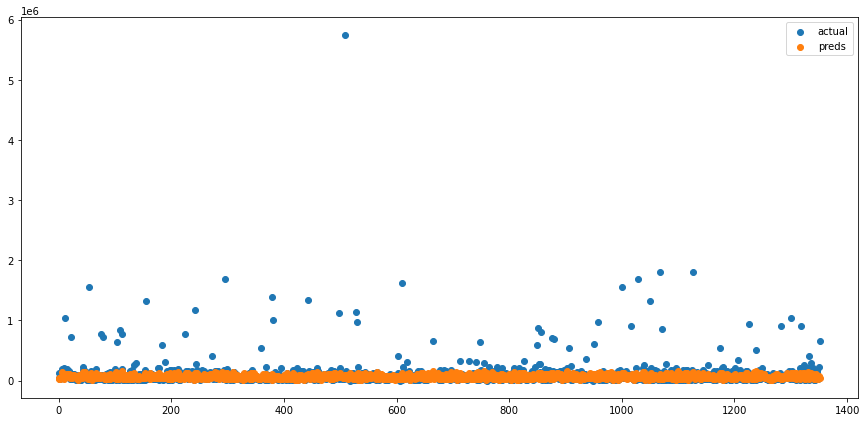

In [398]:
y_holdout_plot = y_holdout.reset_index().drop(columns='index', axis=0)


fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(y_holdout_plot.index, np.exp(y_holdout_plot), label='actual')
plt.scatter(y_holdout_plot.index, np.exp(rf_pred), label='preds')
plt.legend()
# plt.ylim(0, 400000)

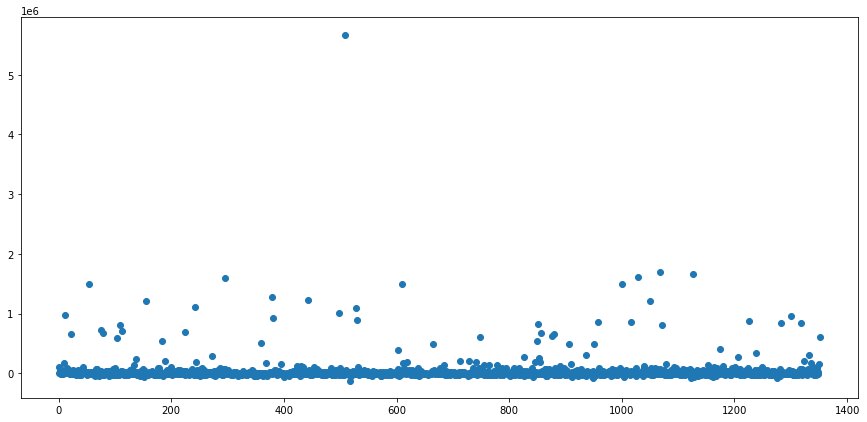

In [399]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(range(len(rf_pred)), np.exp(y_holdout) - np.exp(rf_pred))

In [400]:
np.exp(y_holdout) - np.exp(rf_pred)

index
44210      2004.105113
35335     97264.611572
74268     11995.560794
31060     58423.927662
64914    -11272.790210
             ...      
31664     68922.892372
41903     19828.896071
57243    -10036.184829
38168    154765.642636
62671    612827.276456
Name: ConvertedCompYearly, Length: 1352, dtype: float64

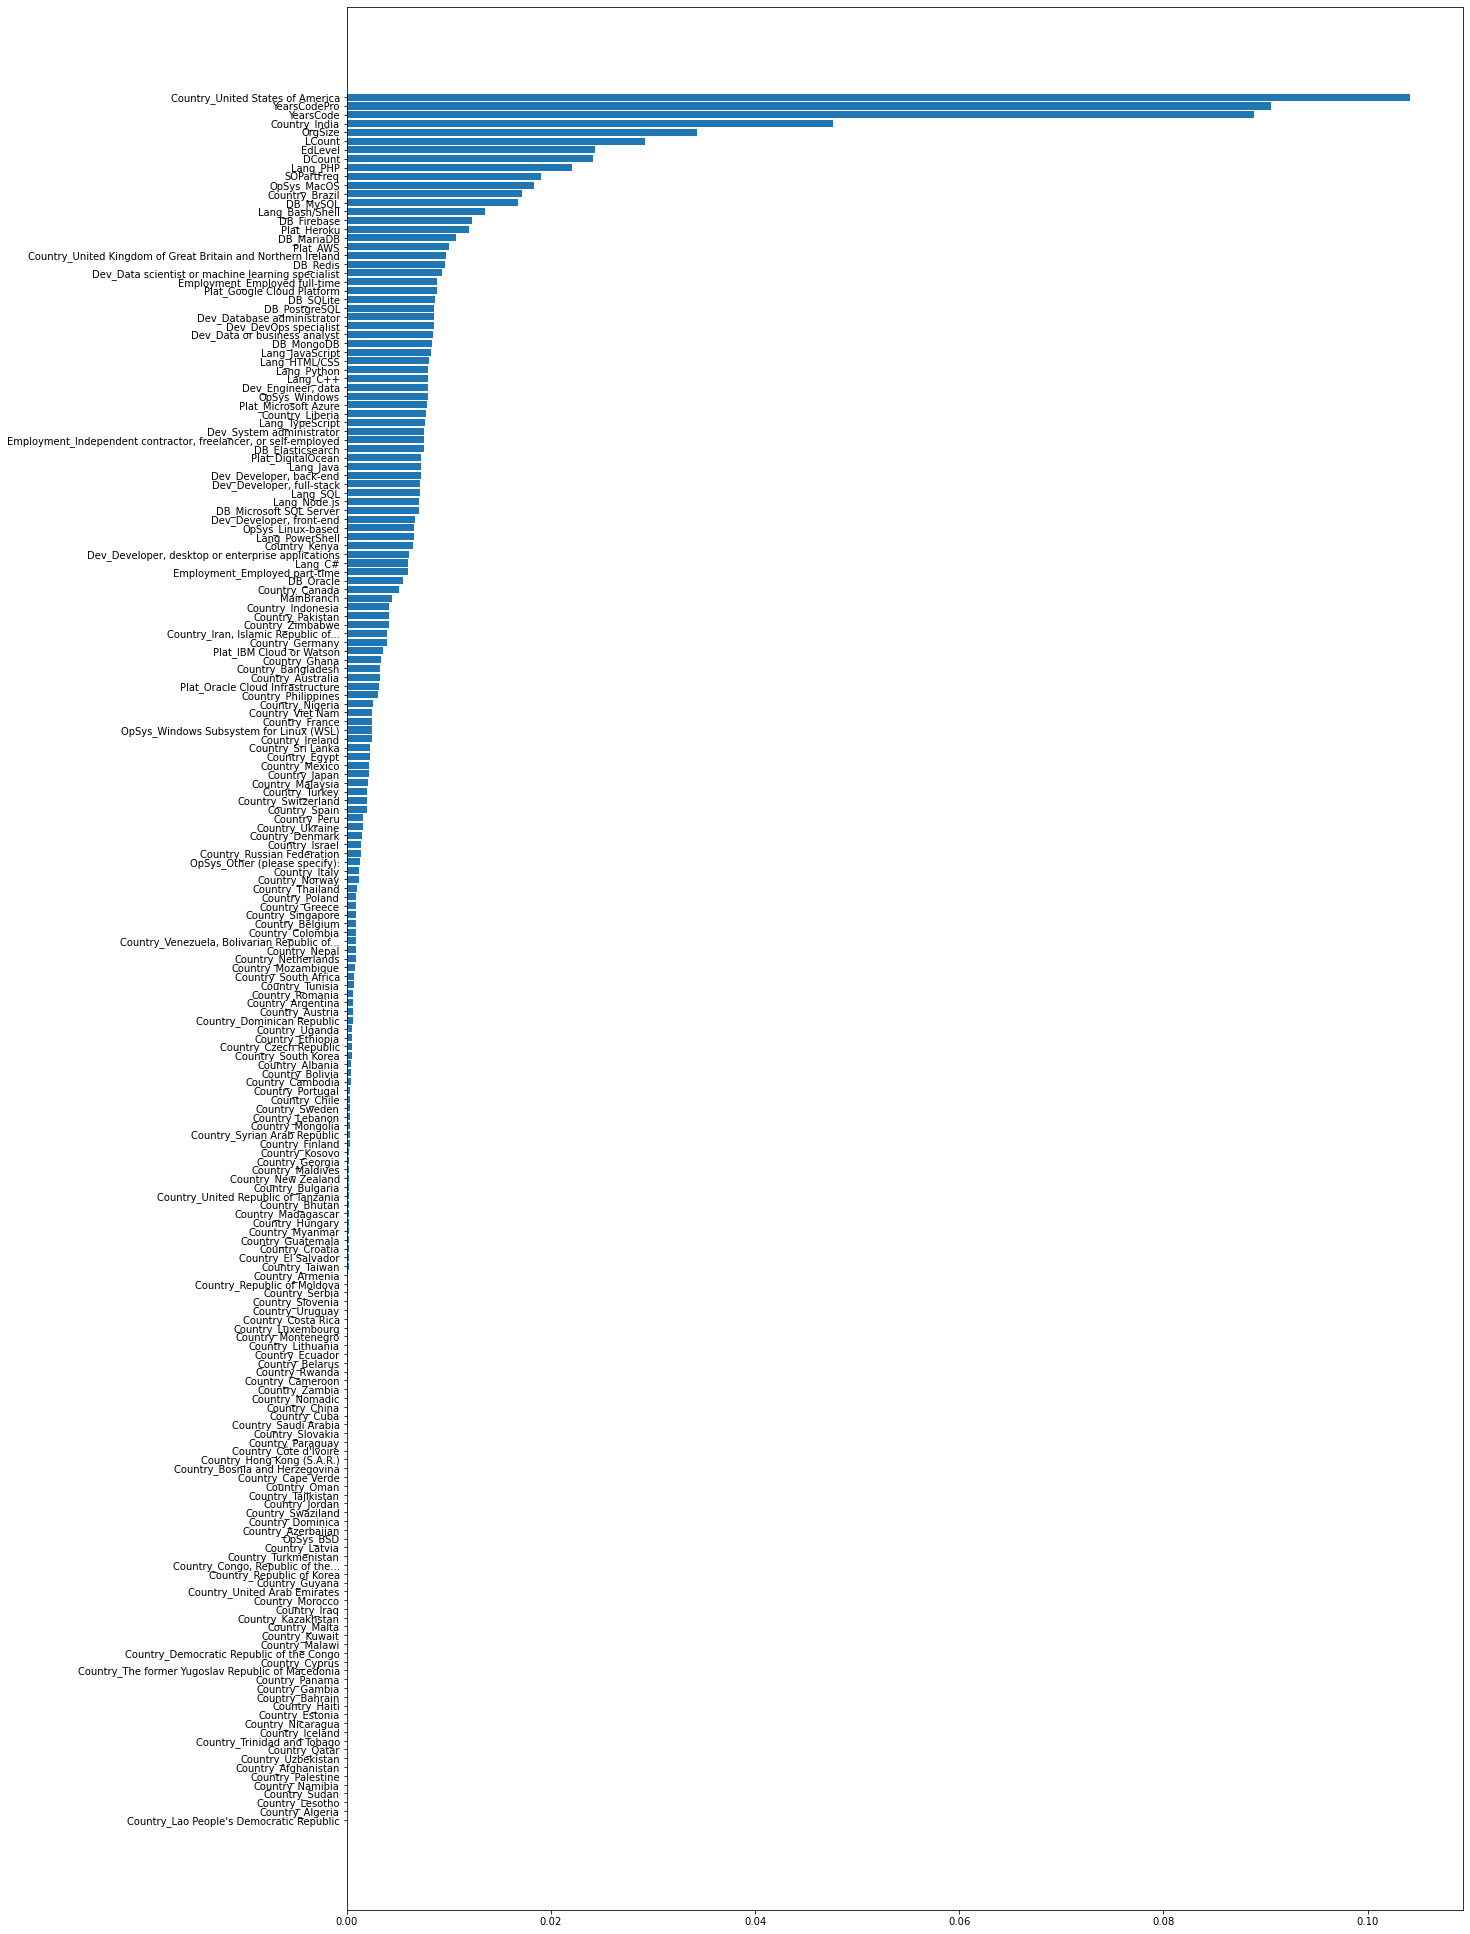

In [401]:
fig, ax = plt.subplots(figsize=(20,35))
plt.barh(X.columns[rf.feature_importances_.argsort()], rf.feature_importances_[rf.feature_importances_.argsort()])
# plt.autoscale()
plt.savefig('rf_feat_imp')

In [402]:
rf.feature_importances_

array([4.25501125e-06, 4.51032120e-04, 0.00000000e+00, 6.34177760e-04,
       1.56884276e-04, 3.23676781e-03, 6.11741473e-04, 3.10215078e-05,
       7.90472384e-06, 3.26265670e-03, 1.00556895e-04, 8.83708672e-04,
       2.11401644e-04, 4.42765009e-04, 4.80543549e-05, 1.71364616e-02,
       2.16384442e-04, 4.11616396e-04, 9.98070497e-05, 5.09450954e-03,
       4.12348350e-05, 3.31942294e-04, 9.31035380e-05, 8.81683140e-04,
       2.65665569e-05, 1.20959240e-04, 1.72729215e-04, 7.70580001e-05,
       9.33796243e-06, 4.68167821e-04, 5.02813512e-05, 1.23914388e-05,
       1.47987721e-03, 3.29442092e-05, 5.89607547e-04, 1.05112749e-04,
       2.23040298e-03, 1.71749126e-04, 6.31488049e-06, 4.78102150e-04,
       2.99649379e-04, 2.46809630e-03, 8.31113728e-06, 2.45761299e-04,
       3.93387410e-03, 3.37944419e-03, 9.32895340e-04, 1.76248827e-04,
       2.36455412e-05, 7.45500107e-06, 4.88774977e-05, 1.95415868e-04,
       5.54080582e-06, 4.76518625e-02, 4.17051679e-03, 3.96050527e-03,
      